In [0]:
import torch 
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **Discriminator**

In [0]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            # N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # N x features_d x 32 x 32
            nn.Conv2d(features_d, features_d * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features_d * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(
                features_d * 2, features_d * 4, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(features_d * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(
                features_d * 4, features_d * 8, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(features_d * 8),
            nn.LeakyReLU(0.2),
            # N x features_d*8 x 4 x 4
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            # N x 1 x 1 x 1
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.net(x)

# **Generator**

In [0]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            # N x channels_noise x 1 x 1
            nn.ConvTranspose2d(
                channels_noise, features_g * 16, kernel_size=4, stride=1, padding=0
            ),
            nn.BatchNorm2d(features_g * 16),
            nn.ReLU(),
            # N x features_g*16 x 4 x 4
            nn.ConvTranspose2d(
                features_g * 16, features_g * 8, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(features_g * 8),
            nn.ReLU(),
            nn.ConvTranspose2d(
                features_g * 8, features_g * 4, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(features_g * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(
                features_g * 4, features_g * 2, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(features_g * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def forward(self, x):
        return self.net(x)

# **DCGAN**

In [0]:
lr = 0.0002
batch_size = 64
image_size = 64
channels_img = 1
channels_noise = 256
num_epochs = 10

features_d = 16
features_g = 16

In [0]:
my_transforms = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)


In [7]:
dataset = datasets.MNIST(
    root="dataset/", train=True, transform=my_transforms, download=True
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
netD = Discriminator(channels_img, features_d).to(device)
netG = Generator(channels_noise, channels_img, features_g).to(device)

In [9]:
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

netG.train()
netD.train()

Discriminator(
  (net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2))
    (12): Sigmoid()
  )
)

In [0]:
criterion = nn.BCELoss()

real_label = 1
fake_label = 0

fixed_noise = torch.randn(64, channels_noise, 1, 1).to(device)

Epoch [0/10] Batch 0/938                   Loss D: 1.4123, loss G: 0.8170 D(x): 0.7007
Epoch [0/10] Batch 100/938                   Loss D: 0.6717, loss G: 3.0221 D(x): 0.8721
Epoch [0/10] Batch 200/938                   Loss D: 0.6963, loss G: 2.1750 D(x): 0.8491
Epoch [0/10] Batch 300/938                   Loss D: 0.7104, loss G: 2.3704 D(x): 0.8237
Epoch [0/10] Batch 400/938                   Loss D: 1.0389, loss G: 3.6829 D(x): 0.9348
Epoch [0/10] Batch 500/938                   Loss D: 0.7769, loss G: 1.7306 D(x): 0.7381
Epoch [0/10] Batch 600/938                   Loss D: 0.7399, loss G: 2.0818 D(x): 0.8371
Epoch [0/10] Batch 700/938                   Loss D: 0.9287, loss G: 2.0569 D(x): 0.8294
Epoch [0/10] Batch 800/938                   Loss D: 0.8650, loss G: 1.0834 D(x): 0.6811
Epoch [0/10] Batch 900/938                   Loss D: 1.0633, loss G: 0.8127 D(x): 0.5071
Epoch [1/10] Batch 0/938                   Loss D: 0.8877, loss G: 1.6586 D(x): 0.8446
Epoch [1/10] Batch 100/93

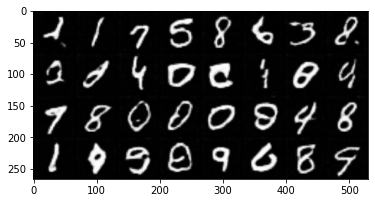

In [14]:
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(dataloader):
        data = data.to(device)
        batch_size = data.shape[0]

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()
        label = (torch.ones(batch_size) * 0.9).to(device)
        output = netD(data).reshape(-1)
        lossD_real = criterion(output, label)
        D_x = output.mean().item()

        noise = torch.randn(batch_size, channels_noise, 1, 1).to(device)
        fake = netG(noise)
        label = (torch.ones(batch_size) * 0.1).to(device)

        output = netD(fake.detach()).reshape(-1)
        lossD_fake = criterion(output, label)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        ### Train Generator: max log(D(G(z)))
        netG.zero_grad()
        label = torch.ones(batch_size).to(device)
        output = netD(fake).reshape(-1)
        lossG = criterion(output, label)
        lossG.backward()
        optimizerG.step()

        # Print losses ocassionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {lossD:.4f}, loss G: {lossG:.4f} D(x): {D_x:.4f}"
            )

            with torch.no_grad():
                fake = netG(fixed_noise)

                img_grid_real = torchvision.utils.make_grid(data[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
                # writer_real.add_image("Mnist Real Images", img_grid_real)
                # writer_real.add_image("Mnist Fake Images", img_grid_fake)
                plt.imshow(np.transpose(img_grid_real.cpu().numpy(), (1,2,0)))
                plt.imshow(np.transpose(img_grid_fake.cpu().numpy(),(1,2,0)))

torch.Size([64, 64])


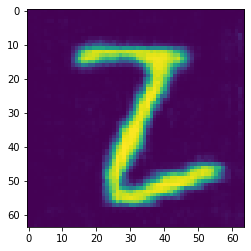

In [24]:
test = netG(torch.randn(1, channels_noise, 1, 1).to(device))
test = test.squeeze()
print(test.shape)
plt.imshow(test.cpu().detach().numpy())